In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

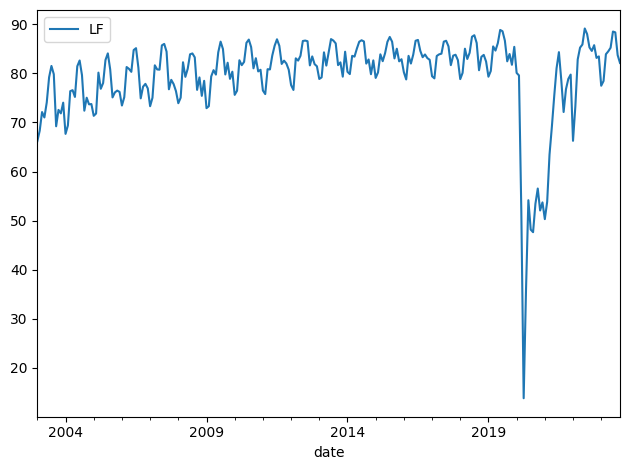

In [2]:
df = pd.read_csv('air traffic.csv')
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

series = pd.concat([df.iloc[:, -1], df['LF']], axis=1).set_index(df['date']).drop('date', axis=1)
series.plot()
plt.tight_layout()
plt.show()

In [25]:
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

dataframe.head()

,t-1,t+1
0,NaN,66.20
1,66.20,68.31
2,68.31,72.12
3,72.12,71.02
4,71.02,74.07


In [26]:
def normalize(data):
    data_norm = (data - data.min()) / (data.max() - data.min())
    
    return data_norm

In [27]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-45], X[len(X)-45:] # testing for 7 values, predictions
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [28]:
train_X_norm, train_y_norm = normalize(train_X), normalize(train_y)
test_X_norm, test_y_norm = normalize(test_X), normalize(test_y)

In [29]:
# split dataset for autoregression model
X = series.values
X_norm = normalize(X)
train_norm, test_norm = X_norm[1:len(X_norm)-45], X_norm[len(X_norm)-45:]

len(train_norm), len(test_norm)

(203, 45)

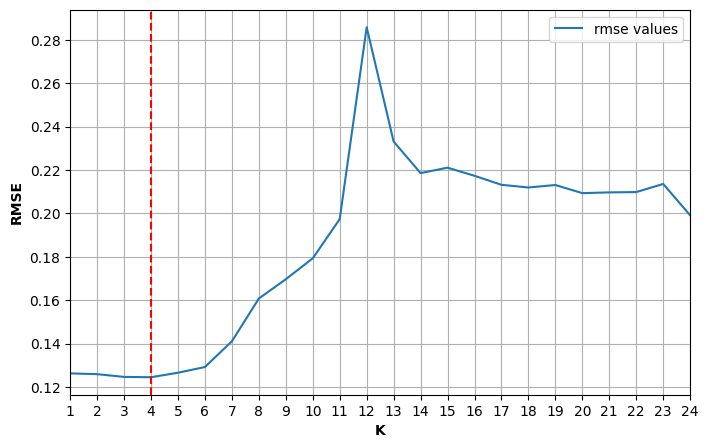

In [30]:
rmse_list = []
window_list = []
windows = 24

for i in range(1, windows+1):
    window = i
    model = AutoReg(train_norm, lags=window)
    model_fit = model.fit()
    coef = model_fit.params

    # walk forward over time steps in test_norm
    history = train_norm[len(train_norm) - window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()

    for t in range(len(test_norm)):
        length = len(history)
        lag = [history[i] for i in range(length-window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        
        obs = test_norm[t]
        predictions.append(yhat)
        history.append(obs)
    
    rmse_list.append(sqrt(mean_squared_error(test_norm, predictions)))
    window_list.append(window)
        
plt.figure(figsize=(8, 5))
plt.plot(window_list, rmse_list, label='rmse values')
plt.xlabel('K', weight='bold')
plt.ylabel('RMSE', weight='bold')
plt.axvline(x=window_list[rmse_list.index(min(rmse_list))], linestyle='--', c='red')
plt.xlim((1, 24))
plt.grid()
plt.xticks(np.arange(1, 25))
plt.legend()
plt.show()

Min Test RMSE: 0.124


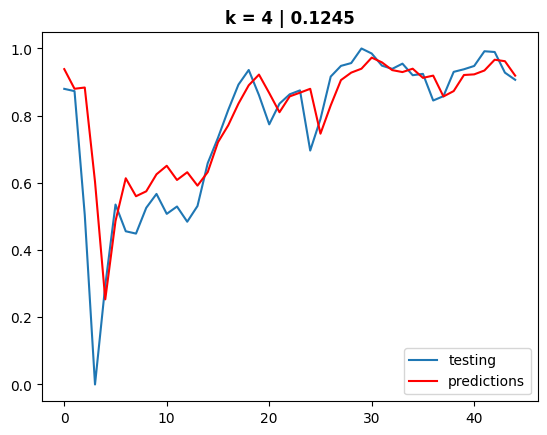

In [35]:
# train_norm autoregression
window = 4
model = AutoReg(train_norm, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test_norm
history = train_norm[len(train_norm) - window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test_norm)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    
    obs = test_norm[t]
    predictions.append(yhat)
    history.append(obs)
        
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = round(sqrt(mean_squared_error(test_norm, predictions)), 4)
print('Min Test RMSE: %.3f' % rmse)
# plot
plt.plot(test_y_norm, label='testing')
plt.plot(predictions, color='red', label='predictions')
plt.title(f'k = {window} | {rmse}', weight='bold')
plt.legend()
plt.show()

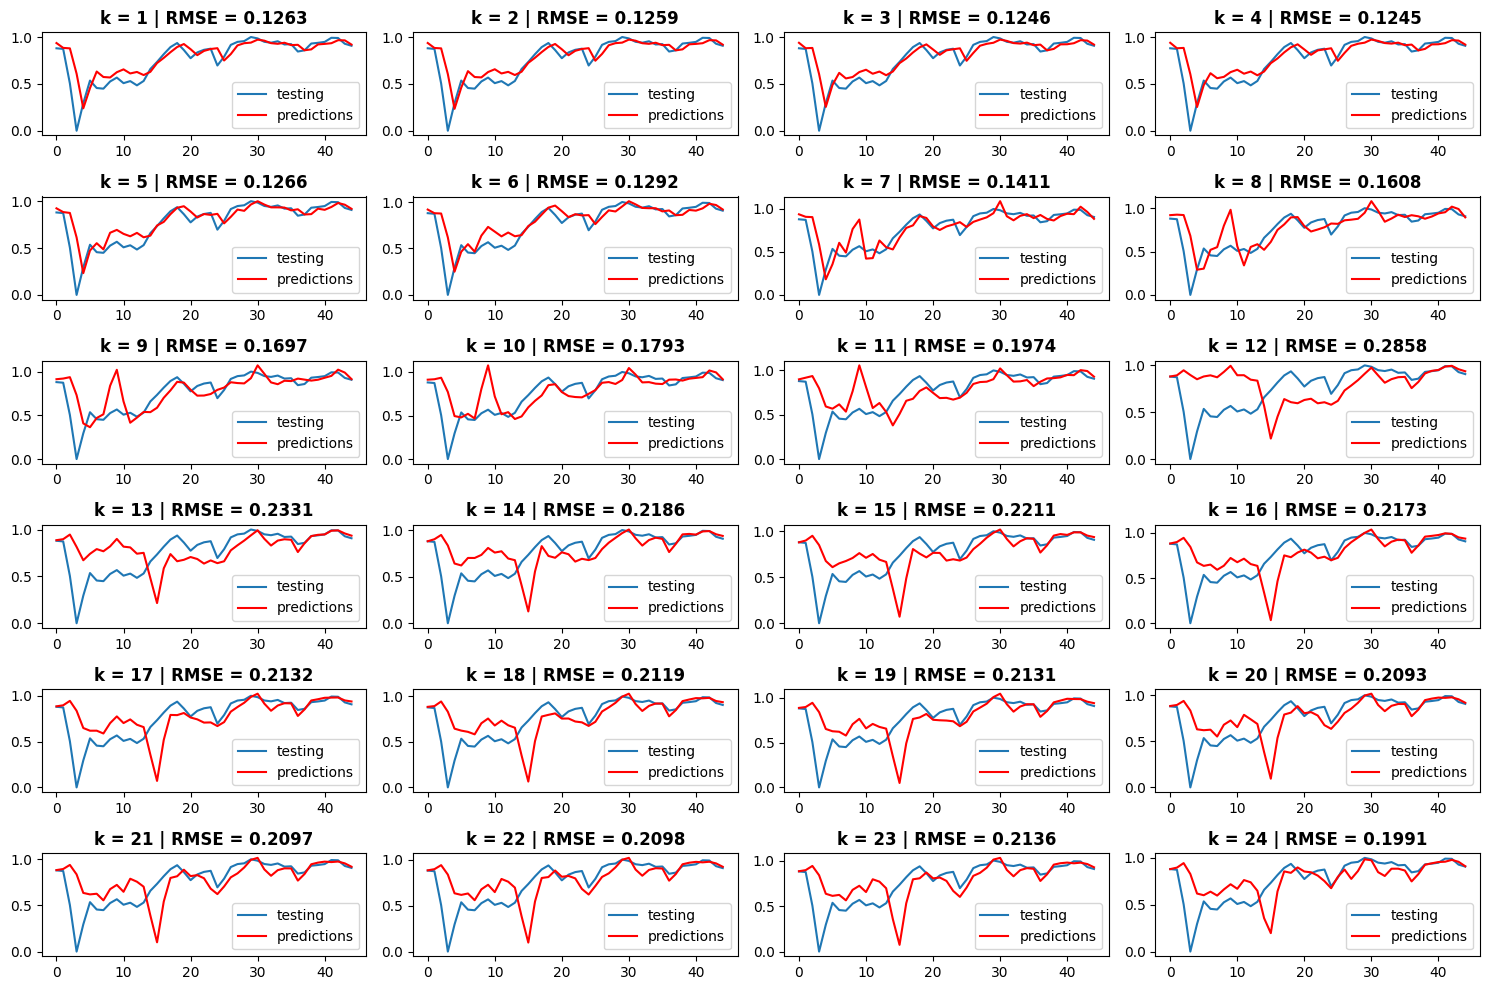

In [36]:
fig, ax = plt.subplots(6, 4, figsize=(15, 10))

i = 1
for nr in range(6):
    for nc in range(4):
        window = i
        model = AutoReg(train_norm, lags=window)
        model_fit = model.fit()
        coef = model_fit.params

        # walk forward over time steps in test_norm
        history = train_norm[len(train_norm) - window:]
        history = [history[i] for i in range(len(history))]
        predictions = list()

        for t in range(len(test_norm)):
            length = len(history)
            lag = [history[i] for i in range(length-window, length)]
            yhat = coef[0]
            for d in range(window):
                yhat += coef[d+1] * lag[window-d-1]
            
            obs = test_norm[t]
            predictions.append(yhat)
            history.append(obs)

        i += 1
            
        rmse = round(sqrt(mean_squared_error(test_norm, predictions)), 4)
        
        ax[nr][nc].plot(test_y_norm, label='testing')
        ax[nr][nc].plot(predictions, color='red', label='predictions')
        ax[nr][nc].set_title(f'k = {window} | RMSE = {rmse}', weight='bold')
        ax[nr][nc].legend()

plt.tight_layout()
plt.show()